# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

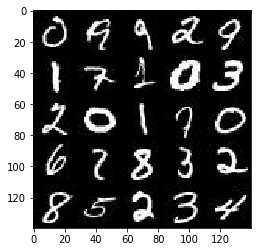

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

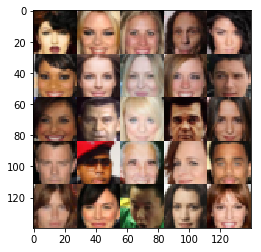

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='real_input')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='generator_input')
    
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return input_real, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        leaky_relu_alpha = 0.01

        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        conv1_relu = tf.maximum(conv1, conv1 * leaky_relu_alpha)
        
        conv2 = tf.layers.conv2d(conv1_relu, 128, 5, strides=2, padding='same')
        conv2_batch_normal = tf.layers.batch_normalization(conv2, training=True)
        conv2_relu = tf.maximum(conv2_batch_normal, conv2_batch_normal * leaky_relu_alpha)
        
        conv3 = tf.layers.conv2d(conv2_relu, 256, 5, strides=2, padding='same')
        conv3_batch_normal = tf.layers.batch_normalization(conv3, training=True)
        conv3_relu = tf.maximum(conv3_batch_normal, conv3_batch_normal * leaky_relu_alpha)
        
        conv3_flat = tf.reshape(conv3_relu, (-1, 4*4*256))
        
        logits = tf.layers.dense(conv3_flat, 1)
        output = tf.sigmoid(logits)

    return output, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        leaky_relu_alpha = 0.01
        
        fc = tf.layers.dense(z, 7*7*512)
        
        fc = tf.reshape(fc, (-1, 7, 7, 512))
        fc_batch_normal = tf.layers.batch_normalization(fc, training=is_train)
        fc_relu = tf.maximum(fc_batch_normal, fc_batch_normal * leaky_relu_alpha)
        
        deconv1 = tf.layers.conv2d_transpose(fc_relu, 256, 5, strides=1, padding='same')
        deconv1_batch_normal = tf.layers.batch_normalization(deconv1, training=is_train)
        deconv1_relu = tf.maximum(deconv1_batch_normal, deconv1_batch_normal * leaky_relu_alpha)
        
        deconv2 = tf.layers.conv2d_transpose(deconv1_relu, 128, 5, strides=2, padding='same')
        deconv2_batch_normal = tf.layers.batch_normalization(deconv2, training=is_train)
        deconv2_relu = tf.maximum(deconv2_batch_normal, deconv2_batch_normal * leaky_relu_alpha)

        logits = tf.layers.conv2d_transpose(deconv2_relu, out_channel_dim, 5, strides=2, padding='same')
        
        output = tf.tanh(logits)
    return output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_out = generator(input_z, out_channel_dim)
    
    disc_out_real, disc_logit_real = discriminator(input_real)
    disc_out_fake, disc_logit_fake = discriminator(gen_out, reuse=True)
    
    disc_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logit_real,
                                                                            labels = tf.ones_like(disc_out_real) * 0.9))
    
    disc_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logit_fake,
                                                                            labels = tf.zeros_like(disc_out_fake)))
    
    disc_loss = disc_loss_real + disc_loss_fake
    
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logit_fake,
                                                                      labels=tf.ones_like(disc_out_fake)))
    
    return disc_loss, gen_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train_vars = tf.trainable_variables()
    
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    disc_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    
    gen_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=gen_vars)
    disc_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=disc_vars)
    
    return disc_opt, gen_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """  
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    input_real, input_z, _ = model_inputs(image_width, image_height, image_channels, z_dim)    
    
    disc_loss, gen_loss = model_loss(input_real, input_z, image_channels)    
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, learning_rate, beta1)
    
    steps = 0
    
    print_output_interval = 10
    show_output_interval = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps = steps + 1
                
                batch_images = batch_images * 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(disc_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(gen_opt, feed_dict={input_z: batch_z})
                
                if steps % print_output_interval == 0:
                    gen_train_loss = gen_loss.eval({input_z: batch_z})
                    disc_train_loss = disc_loss.eval({input_real: batch_images, input_z: batch_z})
                    
                    print("Epoch => {}/{} ".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.3f}".format(disc_train_loss),
                          "Generator Loss: {:.3f}".format(gen_train_loss))
                
                if steps % show_output_interval == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch => 1/2  Discriminator Loss: 2.698 Generator Loss: 0.169
Epoch => 1/2  Discriminator Loss: 0.390 Generator Loss: 7.235
Epoch => 1/2  Discriminator Loss: 3.029 Generator Loss: 15.317
Epoch => 1/2  Discriminator Loss: 0.719 Generator Loss: 2.479
Epoch => 1/2  Discriminator Loss: 0.617 Generator Loss: 3.213
Epoch => 1/2  Discriminator Loss: 0.554 Generator Loss: 2.912
Epoch => 1/2  Discriminator Loss: 0.699 Generator Loss: 5.134
Epoch => 1/2  Discriminator Loss: 1.118 Generator Loss: 1.074
Epoch => 1/2  Discriminator Loss: 1.758 Generator Loss: 3.819
Epoch => 1/2  Discriminator Loss: 0.976 Generator Loss: 1.055


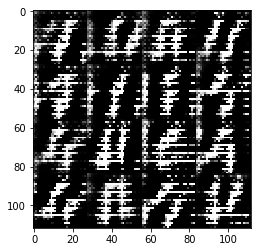

Epoch => 1/2  Discriminator Loss: 1.176 Generator Loss: 1.000
Epoch => 1/2  Discriminator Loss: 1.493 Generator Loss: 0.504
Epoch => 1/2  Discriminator Loss: 1.678 Generator Loss: 0.397
Epoch => 1/2  Discriminator Loss: 1.721 Generator Loss: 2.737
Epoch => 1/2  Discriminator Loss: 1.269 Generator Loss: 0.729
Epoch => 1/2  Discriminator Loss: 1.341 Generator Loss: 0.792
Epoch => 1/2  Discriminator Loss: 1.081 Generator Loss: 1.104
Epoch => 1/2  Discriminator Loss: 1.330 Generator Loss: 0.632
Epoch => 1/2  Discriminator Loss: 1.046 Generator Loss: 1.832
Epoch => 1/2  Discriminator Loss: 1.070 Generator Loss: 1.495


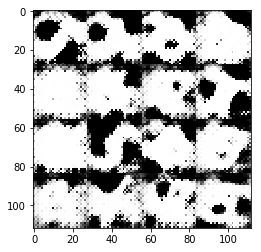

Epoch => 1/2  Discriminator Loss: 1.217 Generator Loss: 0.806
Epoch => 1/2  Discriminator Loss: 1.894 Generator Loss: 0.314
Epoch => 1/2  Discriminator Loss: 1.202 Generator Loss: 1.575
Epoch => 1/2  Discriminator Loss: 1.848 Generator Loss: 2.377
Epoch => 1/2  Discriminator Loss: 1.479 Generator Loss: 0.509
Epoch => 1/2  Discriminator Loss: 1.362 Generator Loss: 1.769
Epoch => 1/2  Discriminator Loss: 1.311 Generator Loss: 0.586
Epoch => 1/2  Discriminator Loss: 1.293 Generator Loss: 0.666
Epoch => 1/2  Discriminator Loss: 1.058 Generator Loss: 0.950
Epoch => 1/2  Discriminator Loss: 1.406 Generator Loss: 0.563


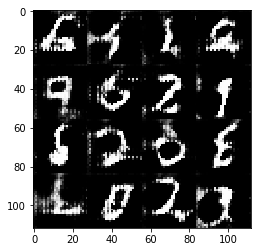

Epoch => 1/2  Discriminator Loss: 1.267 Generator Loss: 0.794
Epoch => 1/2  Discriminator Loss: 1.364 Generator Loss: 1.767
Epoch => 1/2  Discriminator Loss: 1.246 Generator Loss: 0.627
Epoch => 1/2  Discriminator Loss: 1.328 Generator Loss: 0.609
Epoch => 1/2  Discriminator Loss: 1.167 Generator Loss: 0.897
Epoch => 1/2  Discriminator Loss: 1.283 Generator Loss: 0.713
Epoch => 1/2  Discriminator Loss: 1.166 Generator Loss: 0.834
Epoch => 1/2  Discriminator Loss: 1.730 Generator Loss: 2.427
Epoch => 1/2  Discriminator Loss: 1.267 Generator Loss: 1.304
Epoch => 1/2  Discriminator Loss: 1.432 Generator Loss: 0.528


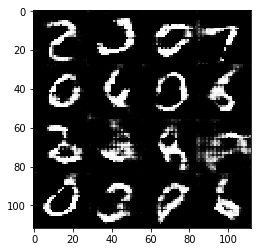

Epoch => 1/2  Discriminator Loss: 1.129 Generator Loss: 0.812
Epoch => 1/2  Discriminator Loss: 1.249 Generator Loss: 0.927
Epoch => 1/2  Discriminator Loss: 1.127 Generator Loss: 1.515
Epoch => 1/2  Discriminator Loss: 1.188 Generator Loss: 0.772
Epoch => 1/2  Discriminator Loss: 1.077 Generator Loss: 1.006
Epoch => 1/2  Discriminator Loss: 1.881 Generator Loss: 2.737
Epoch => 1/2  Discriminator Loss: 1.315 Generator Loss: 0.634
Epoch => 1/2  Discriminator Loss: 1.545 Generator Loss: 0.433
Epoch => 1/2  Discriminator Loss: 1.285 Generator Loss: 1.355
Epoch => 1/2  Discriminator Loss: 1.257 Generator Loss: 0.757


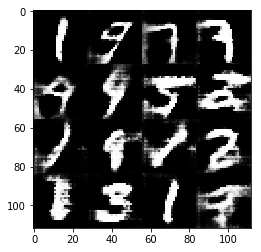

Epoch => 1/2  Discriminator Loss: 1.105 Generator Loss: 0.913
Epoch => 1/2  Discriminator Loss: 1.323 Generator Loss: 1.677
Epoch => 1/2  Discriminator Loss: 1.493 Generator Loss: 0.486
Epoch => 1/2  Discriminator Loss: 1.048 Generator Loss: 1.134
Epoch => 1/2  Discriminator Loss: 1.227 Generator Loss: 1.708
Epoch => 1/2  Discriminator Loss: 1.977 Generator Loss: 0.256
Epoch => 1/2  Discriminator Loss: 1.390 Generator Loss: 1.955
Epoch => 1/2  Discriminator Loss: 1.171 Generator Loss: 0.964
Epoch => 1/2  Discriminator Loss: 1.407 Generator Loss: 0.641
Epoch => 1/2  Discriminator Loss: 1.332 Generator Loss: 0.662


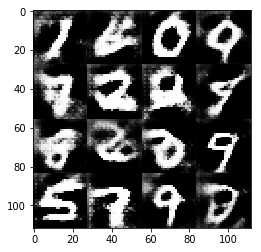

Epoch => 1/2  Discriminator Loss: 1.501 Generator Loss: 0.465
Epoch => 1/2  Discriminator Loss: 1.254 Generator Loss: 0.812
Epoch => 1/2  Discriminator Loss: 1.552 Generator Loss: 2.188
Epoch => 1/2  Discriminator Loss: 1.157 Generator Loss: 1.302
Epoch => 1/2  Discriminator Loss: 1.672 Generator Loss: 0.389
Epoch => 1/2  Discriminator Loss: 1.303 Generator Loss: 1.782
Epoch => 1/2  Discriminator Loss: 1.210 Generator Loss: 0.965
Epoch => 1/2  Discriminator Loss: 1.161 Generator Loss: 1.133
Epoch => 1/2  Discriminator Loss: 1.207 Generator Loss: 1.457
Epoch => 1/2  Discriminator Loss: 1.193 Generator Loss: 1.627


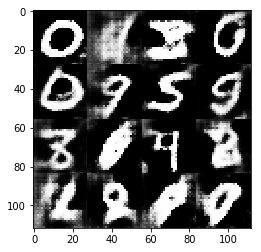

Epoch => 1/2  Discriminator Loss: 1.362 Generator Loss: 0.532
Epoch => 1/2  Discriminator Loss: 1.166 Generator Loss: 0.906
Epoch => 1/2  Discriminator Loss: 1.365 Generator Loss: 0.630
Epoch => 1/2  Discriminator Loss: 1.232 Generator Loss: 1.287
Epoch => 1/2  Discriminator Loss: 1.242 Generator Loss: 1.564
Epoch => 1/2  Discriminator Loss: 1.265 Generator Loss: 0.674
Epoch => 1/2  Discriminator Loss: 1.175 Generator Loss: 0.862
Epoch => 1/2  Discriminator Loss: 1.635 Generator Loss: 0.419
Epoch => 1/2  Discriminator Loss: 1.781 Generator Loss: 0.346
Epoch => 1/2  Discriminator Loss: 1.491 Generator Loss: 0.468


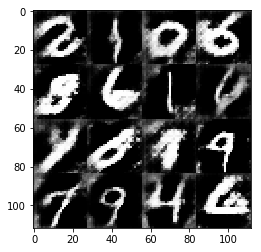

Epoch => 1/2  Discriminator Loss: 1.058 Generator Loss: 1.421
Epoch => 1/2  Discriminator Loss: 1.146 Generator Loss: 1.445
Epoch => 1/2  Discriminator Loss: 1.203 Generator Loss: 0.721
Epoch => 1/2  Discriminator Loss: 1.455 Generator Loss: 0.548
Epoch => 1/2  Discriminator Loss: 1.679 Generator Loss: 0.377
Epoch => 1/2  Discriminator Loss: 1.406 Generator Loss: 0.541
Epoch => 1/2  Discriminator Loss: 1.111 Generator Loss: 0.894
Epoch => 1/2  Discriminator Loss: 1.540 Generator Loss: 0.470
Epoch => 1/2  Discriminator Loss: 1.322 Generator Loss: 0.745
Epoch => 1/2  Discriminator Loss: 1.360 Generator Loss: 0.696


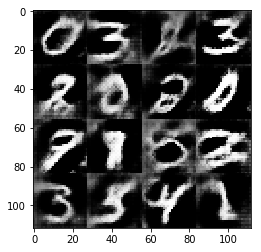

Epoch => 1/2  Discriminator Loss: 1.473 Generator Loss: 0.503
Epoch => 1/2  Discriminator Loss: 1.167 Generator Loss: 0.781
Epoch => 1/2  Discriminator Loss: 1.278 Generator Loss: 0.927
Epoch => 2/2  Discriminator Loss: 1.149 Generator Loss: 0.874
Epoch => 2/2  Discriminator Loss: 1.265 Generator Loss: 0.655
Epoch => 2/2  Discriminator Loss: 1.212 Generator Loss: 0.698
Epoch => 2/2  Discriminator Loss: 1.595 Generator Loss: 2.214
Epoch => 2/2  Discriminator Loss: 1.270 Generator Loss: 0.864
Epoch => 2/2  Discriminator Loss: 1.225 Generator Loss: 0.727
Epoch => 2/2  Discriminator Loss: 1.239 Generator Loss: 0.761


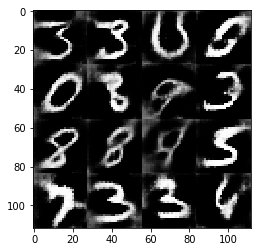

Epoch => 2/2  Discriminator Loss: 1.147 Generator Loss: 0.863
Epoch => 2/2  Discriminator Loss: 1.152 Generator Loss: 0.922
Epoch => 2/2  Discriminator Loss: 1.349 Generator Loss: 0.686
Epoch => 2/2  Discriminator Loss: 1.618 Generator Loss: 0.420
Epoch => 2/2  Discriminator Loss: 1.178 Generator Loss: 0.924
Epoch => 2/2  Discriminator Loss: 1.687 Generator Loss: 0.409
Epoch => 2/2  Discriminator Loss: 1.139 Generator Loss: 1.069
Epoch => 2/2  Discriminator Loss: 1.324 Generator Loss: 0.616
Epoch => 2/2  Discriminator Loss: 1.135 Generator Loss: 1.111
Epoch => 2/2  Discriminator Loss: 1.560 Generator Loss: 0.433


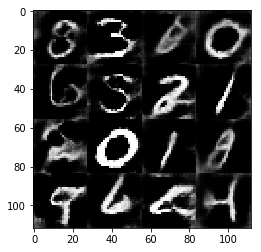

Epoch => 2/2  Discriminator Loss: 1.404 Generator Loss: 1.815
Epoch => 2/2  Discriminator Loss: 1.260 Generator Loss: 1.676
Epoch => 2/2  Discriminator Loss: 1.289 Generator Loss: 0.646
Epoch => 2/2  Discriminator Loss: 1.340 Generator Loss: 0.619
Epoch => 2/2  Discriminator Loss: 1.266 Generator Loss: 1.532
Epoch => 2/2  Discriminator Loss: 1.706 Generator Loss: 0.372
Epoch => 2/2  Discriminator Loss: 1.270 Generator Loss: 1.057
Epoch => 2/2  Discriminator Loss: 1.139 Generator Loss: 1.217
Epoch => 2/2  Discriminator Loss: 2.364 Generator Loss: 0.185
Epoch => 2/2  Discriminator Loss: 1.448 Generator Loss: 0.570


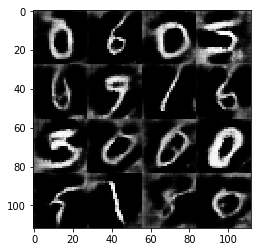

Epoch => 2/2  Discriminator Loss: 1.233 Generator Loss: 0.704
Epoch => 2/2  Discriminator Loss: 1.052 Generator Loss: 1.051
Epoch => 2/2  Discriminator Loss: 1.144 Generator Loss: 0.832
Epoch => 2/2  Discriminator Loss: 1.480 Generator Loss: 2.045
Epoch => 2/2  Discriminator Loss: 1.198 Generator Loss: 0.765
Epoch => 2/2  Discriminator Loss: 1.352 Generator Loss: 0.597
Epoch => 2/2  Discriminator Loss: 1.404 Generator Loss: 1.318
Epoch => 2/2  Discriminator Loss: 1.282 Generator Loss: 0.690
Epoch => 2/2  Discriminator Loss: 1.249 Generator Loss: 1.504
Epoch => 2/2  Discriminator Loss: 1.222 Generator Loss: 0.779


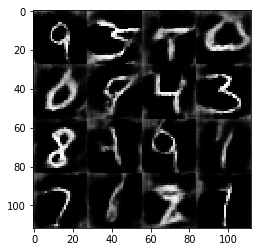

Epoch => 2/2  Discriminator Loss: 1.470 Generator Loss: 0.479
Epoch => 2/2  Discriminator Loss: 1.228 Generator Loss: 1.277
Epoch => 2/2  Discriminator Loss: 1.693 Generator Loss: 0.360
Epoch => 2/2  Discriminator Loss: 1.205 Generator Loss: 1.509
Epoch => 2/2  Discriminator Loss: 1.156 Generator Loss: 0.929
Epoch => 2/2  Discriminator Loss: 1.102 Generator Loss: 0.883
Epoch => 2/2  Discriminator Loss: 2.237 Generator Loss: 0.228
Epoch => 2/2  Discriminator Loss: 1.348 Generator Loss: 0.619
Epoch => 2/2  Discriminator Loss: 1.286 Generator Loss: 0.743
Epoch => 2/2  Discriminator Loss: 1.363 Generator Loss: 1.332


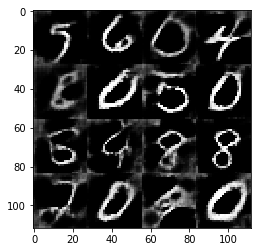

Epoch => 2/2  Discriminator Loss: 1.122 Generator Loss: 0.970
Epoch => 2/2  Discriminator Loss: 1.172 Generator Loss: 1.158
Epoch => 2/2  Discriminator Loss: 1.776 Generator Loss: 0.341
Epoch => 2/2  Discriminator Loss: 1.321 Generator Loss: 1.266
Epoch => 2/2  Discriminator Loss: 1.262 Generator Loss: 1.355
Epoch => 2/2  Discriminator Loss: 1.091 Generator Loss: 1.459
Epoch => 2/2  Discriminator Loss: 1.403 Generator Loss: 0.598
Epoch => 2/2  Discriminator Loss: 1.181 Generator Loss: 0.856
Epoch => 2/2  Discriminator Loss: 1.269 Generator Loss: 1.431
Epoch => 2/2  Discriminator Loss: 1.419 Generator Loss: 0.584


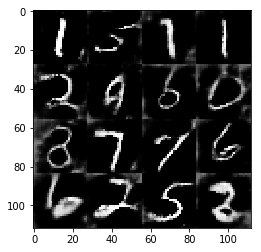

Epoch => 2/2  Discriminator Loss: 1.797 Generator Loss: 1.966
Epoch => 2/2  Discriminator Loss: 1.377 Generator Loss: 0.624
Epoch => 2/2  Discriminator Loss: 1.117 Generator Loss: 0.950
Epoch => 2/2  Discriminator Loss: 1.269 Generator Loss: 1.314
Epoch => 2/2  Discriminator Loss: 1.514 Generator Loss: 0.472
Epoch => 2/2  Discriminator Loss: 2.203 Generator Loss: 0.222
Epoch => 2/2  Discriminator Loss: 1.201 Generator Loss: 1.249
Epoch => 2/2  Discriminator Loss: 1.357 Generator Loss: 0.566
Epoch => 2/2  Discriminator Loss: 1.962 Generator Loss: 0.274
Epoch => 2/2  Discriminator Loss: 1.330 Generator Loss: 0.570


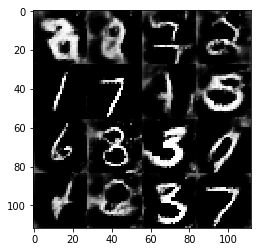

Epoch => 2/2  Discriminator Loss: 1.287 Generator Loss: 0.660
Epoch => 2/2  Discriminator Loss: 2.072 Generator Loss: 0.236
Epoch => 2/2  Discriminator Loss: 1.199 Generator Loss: 0.821
Epoch => 2/2  Discriminator Loss: 1.219 Generator Loss: 0.675
Epoch => 2/2  Discriminator Loss: 1.296 Generator Loss: 0.799
Epoch => 2/2  Discriminator Loss: 1.133 Generator Loss: 0.895
Epoch => 2/2  Discriminator Loss: 1.454 Generator Loss: 0.490
Epoch => 2/2  Discriminator Loss: 1.153 Generator Loss: 2.203
Epoch => 2/2  Discriminator Loss: 1.785 Generator Loss: 0.323
Epoch => 2/2  Discriminator Loss: 1.015 Generator Loss: 1.515


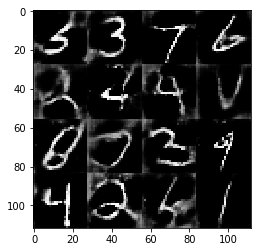

Epoch => 2/2  Discriminator Loss: 0.900 Generator Loss: 1.077
Epoch => 2/2  Discriminator Loss: 1.266 Generator Loss: 1.072
Epoch => 2/2  Discriminator Loss: 1.406 Generator Loss: 0.619
Epoch => 2/2  Discriminator Loss: 1.204 Generator Loss: 1.023
Epoch => 2/2  Discriminator Loss: 1.144 Generator Loss: 1.115
Epoch => 2/2  Discriminator Loss: 1.475 Generator Loss: 0.485
Epoch => 2/2  Discriminator Loss: 1.480 Generator Loss: 2.234
Epoch => 2/2  Discriminator Loss: 1.277 Generator Loss: 0.596
Epoch => 2/2  Discriminator Loss: 1.237 Generator Loss: 0.768
Epoch => 2/2  Discriminator Loss: 1.284 Generator Loss: 1.520


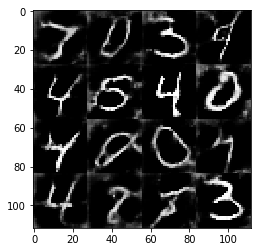

Epoch => 2/2  Discriminator Loss: 1.471 Generator Loss: 0.500
Epoch => 2/2  Discriminator Loss: 1.178 Generator Loss: 0.715
Epoch => 2/2  Discriminator Loss: 1.158 Generator Loss: 0.884
Epoch => 2/2  Discriminator Loss: 1.097 Generator Loss: 1.039
Epoch => 2/2  Discriminator Loss: 1.105 Generator Loss: 0.913
Epoch => 2/2  Discriminator Loss: 1.088 Generator Loss: 1.055
Epoch => 2/2  Discriminator Loss: 1.864 Generator Loss: 0.297


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch => 1/1  Discriminator Loss: 3.924 Generator Loss: 16.949
Epoch => 1/1  Discriminator Loss: 3.546 Generator Loss: 15.662
Epoch => 1/1  Discriminator Loss: 1.546 Generator Loss: 3.467
Epoch => 1/1  Discriminator Loss: 1.527 Generator Loss: 0.558
Epoch => 1/1  Discriminator Loss: 1.030 Generator Loss: 2.297
Epoch => 1/1  Discriminator Loss: 0.858 Generator Loss: 1.534
Epoch => 1/1  Discriminator Loss: 1.484 Generator Loss: 2.793
Epoch => 1/1  Discriminator Loss: 1.230 Generator Loss: 0.708
Epoch => 1/1  Discriminator Loss: 0.986 Generator Loss: 2.103
Epoch => 1/1  Discriminator Loss: 0.947 Generator Loss: 1.999


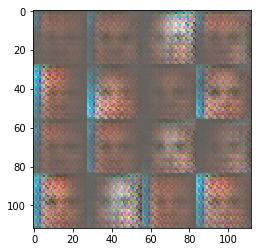

Epoch => 1/1  Discriminator Loss: 1.004 Generator Loss: 2.174
Epoch => 1/1  Discriminator Loss: 0.943 Generator Loss: 1.177
Epoch => 1/1  Discriminator Loss: 2.726 Generator Loss: 0.250
Epoch => 1/1  Discriminator Loss: 1.691 Generator Loss: 0.756
Epoch => 1/1  Discriminator Loss: 1.097 Generator Loss: 1.767
Epoch => 1/1  Discriminator Loss: 1.271 Generator Loss: 0.705
Epoch => 1/1  Discriminator Loss: 1.741 Generator Loss: 2.627
Epoch => 1/1  Discriminator Loss: 1.260 Generator Loss: 1.046
Epoch => 1/1  Discriminator Loss: 1.644 Generator Loss: 3.041
Epoch => 1/1  Discriminator Loss: 0.901 Generator Loss: 1.278


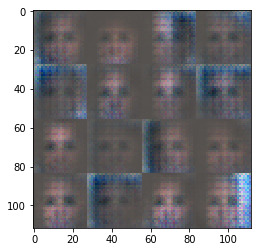

Epoch => 1/1  Discriminator Loss: 1.097 Generator Loss: 1.725
Epoch => 1/1  Discriminator Loss: 0.632 Generator Loss: 1.676
Epoch => 1/1  Discriminator Loss: 1.338 Generator Loss: 0.772
Epoch => 1/1  Discriminator Loss: 1.186 Generator Loss: 0.891
Epoch => 1/1  Discriminator Loss: 1.407 Generator Loss: 0.869
Epoch => 1/1  Discriminator Loss: 0.905 Generator Loss: 1.136
Epoch => 1/1  Discriminator Loss: 0.988 Generator Loss: 1.414
Epoch => 1/1  Discriminator Loss: 1.097 Generator Loss: 1.583
Epoch => 1/1  Discriminator Loss: 1.435 Generator Loss: 0.497
Epoch => 1/1  Discriminator Loss: 0.819 Generator Loss: 1.096


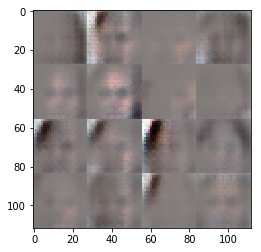

Epoch => 1/1  Discriminator Loss: 1.486 Generator Loss: 0.670
Epoch => 1/1  Discriminator Loss: 1.095 Generator Loss: 1.024
Epoch => 1/1  Discriminator Loss: 0.698 Generator Loss: 1.263
Epoch => 1/1  Discriminator Loss: 1.062 Generator Loss: 1.041
Epoch => 1/1  Discriminator Loss: 0.892 Generator Loss: 0.978
Epoch => 1/1  Discriminator Loss: 0.886 Generator Loss: 0.991
Epoch => 1/1  Discriminator Loss: 1.226 Generator Loss: 1.160
Epoch => 1/1  Discriminator Loss: 1.017 Generator Loss: 0.942
Epoch => 1/1  Discriminator Loss: 1.191 Generator Loss: 0.931
Epoch => 1/1  Discriminator Loss: 1.078 Generator Loss: 0.847


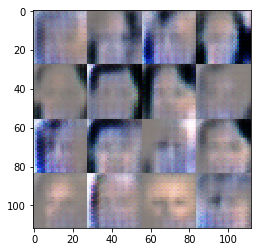

Epoch => 1/1  Discriminator Loss: 1.133 Generator Loss: 1.401
Epoch => 1/1  Discriminator Loss: 1.138 Generator Loss: 1.233
Epoch => 1/1  Discriminator Loss: 0.853 Generator Loss: 1.828
Epoch => 1/1  Discriminator Loss: 0.955 Generator Loss: 0.971
Epoch => 1/1  Discriminator Loss: 0.889 Generator Loss: 1.041
Epoch => 1/1  Discriminator Loss: 0.790 Generator Loss: 1.444
Epoch => 1/1  Discriminator Loss: 1.249 Generator Loss: 1.082
Epoch => 1/1  Discriminator Loss: 0.611 Generator Loss: 1.620
Epoch => 1/1  Discriminator Loss: 0.529 Generator Loss: 2.522
Epoch => 1/1  Discriminator Loss: 1.800 Generator Loss: 2.565


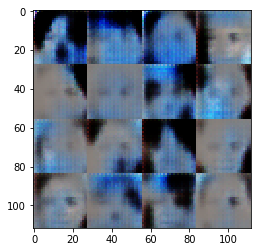

Epoch => 1/1  Discriminator Loss: 0.520 Generator Loss: 2.024
Epoch => 1/1  Discriminator Loss: 0.883 Generator Loss: 1.520
Epoch => 1/1  Discriminator Loss: 1.305 Generator Loss: 2.779
Epoch => 1/1  Discriminator Loss: 0.832 Generator Loss: 1.227
Epoch => 1/1  Discriminator Loss: 1.228 Generator Loss: 1.825
Epoch => 1/1  Discriminator Loss: 0.908 Generator Loss: 1.198
Epoch => 1/1  Discriminator Loss: 0.702 Generator Loss: 3.915
Epoch => 1/1  Discriminator Loss: 0.681 Generator Loss: 1.544
Epoch => 1/1  Discriminator Loss: 1.129 Generator Loss: 0.716
Epoch => 1/1  Discriminator Loss: 1.012 Generator Loss: 1.267


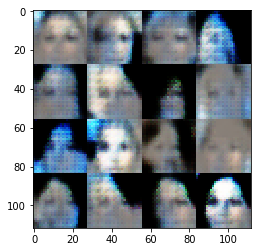

Epoch => 1/1  Discriminator Loss: 0.921 Generator Loss: 0.926
Epoch => 1/1  Discriminator Loss: 0.878 Generator Loss: 1.600
Epoch => 1/1  Discriminator Loss: 1.276 Generator Loss: 0.848
Epoch => 1/1  Discriminator Loss: 1.393 Generator Loss: 0.617
Epoch => 1/1  Discriminator Loss: 2.050 Generator Loss: 0.289
Epoch => 1/1  Discriminator Loss: 0.958 Generator Loss: 0.955
Epoch => 1/1  Discriminator Loss: 1.229 Generator Loss: 0.712
Epoch => 1/1  Discriminator Loss: 0.938 Generator Loss: 1.126
Epoch => 1/1  Discriminator Loss: 0.854 Generator Loss: 1.014
Epoch => 1/1  Discriminator Loss: 1.202 Generator Loss: 0.712


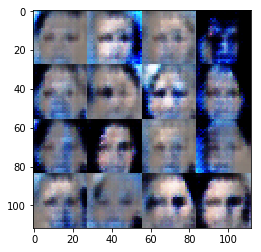

Epoch => 1/1  Discriminator Loss: 1.205 Generator Loss: 0.617
Epoch => 1/1  Discriminator Loss: 1.013 Generator Loss: 1.370
Epoch => 1/1  Discriminator Loss: 1.033 Generator Loss: 1.212
Epoch => 1/1  Discriminator Loss: 1.545 Generator Loss: 0.529
Epoch => 1/1  Discriminator Loss: 0.838 Generator Loss: 1.442
Epoch => 1/1  Discriminator Loss: 1.185 Generator Loss: 1.051
Epoch => 1/1  Discriminator Loss: 1.079 Generator Loss: 0.867
Epoch => 1/1  Discriminator Loss: 1.035 Generator Loss: 1.689
Epoch => 1/1  Discriminator Loss: 1.069 Generator Loss: 1.272
Epoch => 1/1  Discriminator Loss: 1.329 Generator Loss: 0.721


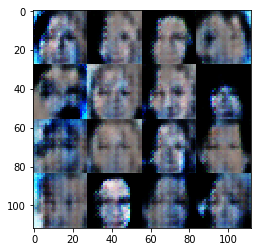

Epoch => 1/1  Discriminator Loss: 0.987 Generator Loss: 0.994
Epoch => 1/1  Discriminator Loss: 1.178 Generator Loss: 1.744
Epoch => 1/1  Discriminator Loss: 1.172 Generator Loss: 0.798
Epoch => 1/1  Discriminator Loss: 0.981 Generator Loss: 1.106
Epoch => 1/1  Discriminator Loss: 0.807 Generator Loss: 1.255
Epoch => 1/1  Discriminator Loss: 1.050 Generator Loss: 1.005
Epoch => 1/1  Discriminator Loss: 3.535 Generator Loss: 5.254
Epoch => 1/1  Discriminator Loss: 0.919 Generator Loss: 0.909
Epoch => 1/1  Discriminator Loss: 1.003 Generator Loss: 1.505
Epoch => 1/1  Discriminator Loss: 0.878 Generator Loss: 1.225


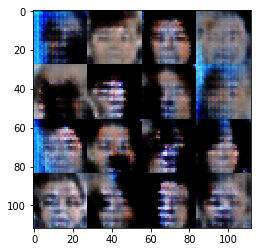

Epoch => 1/1  Discriminator Loss: 1.798 Generator Loss: 0.311
Epoch => 1/1  Discriminator Loss: 0.916 Generator Loss: 0.932
Epoch => 1/1  Discriminator Loss: 1.034 Generator Loss: 0.781
Epoch => 1/1  Discriminator Loss: 1.189 Generator Loss: 0.962
Epoch => 1/1  Discriminator Loss: 1.065 Generator Loss: 1.009
Epoch => 1/1  Discriminator Loss: 1.564 Generator Loss: 0.516
Epoch => 1/1  Discriminator Loss: 0.853 Generator Loss: 1.210
Epoch => 1/1  Discriminator Loss: 1.367 Generator Loss: 0.848
Epoch => 1/1  Discriminator Loss: 1.301 Generator Loss: 0.682
Epoch => 1/1  Discriminator Loss: 1.435 Generator Loss: 1.372


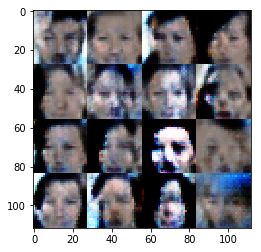

Epoch => 1/1  Discriminator Loss: 0.961 Generator Loss: 1.592
Epoch => 1/1  Discriminator Loss: 1.007 Generator Loss: 1.284
Epoch => 1/1  Discriminator Loss: 1.123 Generator Loss: 1.496
Epoch => 1/1  Discriminator Loss: 1.062 Generator Loss: 1.365
Epoch => 1/1  Discriminator Loss: 1.629 Generator Loss: 0.721
Epoch => 1/1  Discriminator Loss: 1.186 Generator Loss: 0.993
Epoch => 1/1  Discriminator Loss: 0.977 Generator Loss: 0.901
Epoch => 1/1  Discriminator Loss: 0.898 Generator Loss: 1.077
Epoch => 1/1  Discriminator Loss: 0.935 Generator Loss: 1.413
Epoch => 1/1  Discriminator Loss: 1.209 Generator Loss: 0.656


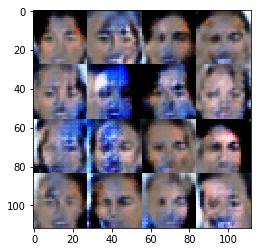

Epoch => 1/1  Discriminator Loss: 1.021 Generator Loss: 1.461
Epoch => 1/1  Discriminator Loss: 1.167 Generator Loss: 0.949
Epoch => 1/1  Discriminator Loss: 1.084 Generator Loss: 1.475
Epoch => 1/1  Discriminator Loss: 1.556 Generator Loss: 0.749
Epoch => 1/1  Discriminator Loss: 1.223 Generator Loss: 0.912
Epoch => 1/1  Discriminator Loss: 0.810 Generator Loss: 1.215
Epoch => 1/1  Discriminator Loss: 1.596 Generator Loss: 0.456
Epoch => 1/1  Discriminator Loss: 1.352 Generator Loss: 1.313
Epoch => 1/1  Discriminator Loss: 0.792 Generator Loss: 1.356
Epoch => 1/1  Discriminator Loss: 0.849 Generator Loss: 1.148


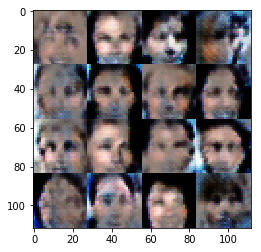

Epoch => 1/1  Discriminator Loss: 0.869 Generator Loss: 1.562
Epoch => 1/1  Discriminator Loss: 1.988 Generator Loss: 0.471
Epoch => 1/1  Discriminator Loss: 1.075 Generator Loss: 0.765
Epoch => 1/1  Discriminator Loss: 1.178 Generator Loss: 0.951
Epoch => 1/1  Discriminator Loss: 0.902 Generator Loss: 1.370
Epoch => 1/1  Discriminator Loss: 1.221 Generator Loss: 0.816
Epoch => 1/1  Discriminator Loss: 1.229 Generator Loss: 0.618
Epoch => 1/1  Discriminator Loss: 0.807 Generator Loss: 1.454
Epoch => 1/1  Discriminator Loss: 1.016 Generator Loss: 1.096
Epoch => 1/1  Discriminator Loss: 1.180 Generator Loss: 1.611


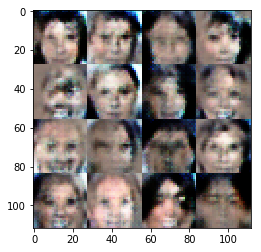

Epoch => 1/1  Discriminator Loss: 0.971 Generator Loss: 0.959
Epoch => 1/1  Discriminator Loss: 1.102 Generator Loss: 0.894
Epoch => 1/1  Discriminator Loss: 1.197 Generator Loss: 0.936
Epoch => 1/1  Discriminator Loss: 1.003 Generator Loss: 1.060
Epoch => 1/1  Discriminator Loss: 1.254 Generator Loss: 0.824
Epoch => 1/1  Discriminator Loss: 1.153 Generator Loss: 0.976
Epoch => 1/1  Discriminator Loss: 1.280 Generator Loss: 0.672
Epoch => 1/1  Discriminator Loss: 1.129 Generator Loss: 1.189
Epoch => 1/1  Discriminator Loss: 1.174 Generator Loss: 0.701
Epoch => 1/1  Discriminator Loss: 1.299 Generator Loss: 0.926


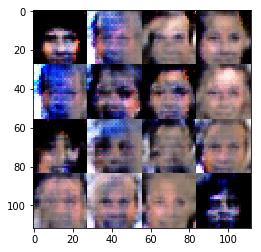

Epoch => 1/1  Discriminator Loss: 1.508 Generator Loss: 0.715
Epoch => 1/1  Discriminator Loss: 1.193 Generator Loss: 1.430
Epoch => 1/1  Discriminator Loss: 1.037 Generator Loss: 0.912
Epoch => 1/1  Discriminator Loss: 1.391 Generator Loss: 0.704
Epoch => 1/1  Discriminator Loss: 1.111 Generator Loss: 1.038
Epoch => 1/1  Discriminator Loss: 1.298 Generator Loss: 1.618
Epoch => 1/1  Discriminator Loss: 1.026 Generator Loss: 0.896
Epoch => 1/1  Discriminator Loss: 1.189 Generator Loss: 0.799
Epoch => 1/1  Discriminator Loss: 1.447 Generator Loss: 0.912
Epoch => 1/1  Discriminator Loss: 0.855 Generator Loss: 1.206


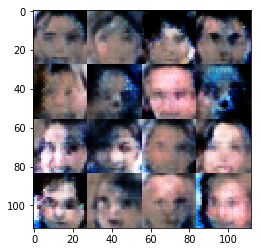

Epoch => 1/1  Discriminator Loss: 1.057 Generator Loss: 0.790
Epoch => 1/1  Discriminator Loss: 1.153 Generator Loss: 1.235
Epoch => 1/1  Discriminator Loss: 1.155 Generator Loss: 0.723
Epoch => 1/1  Discriminator Loss: 1.000 Generator Loss: 0.886
Epoch => 1/1  Discriminator Loss: 1.453 Generator Loss: 0.475
Epoch => 1/1  Discriminator Loss: 1.225 Generator Loss: 1.367
Epoch => 1/1  Discriminator Loss: 1.488 Generator Loss: 0.916
Epoch => 1/1  Discriminator Loss: 0.608 Generator Loss: 1.673
Epoch => 1/1  Discriminator Loss: 1.251 Generator Loss: 1.650
Epoch => 1/1  Discriminator Loss: 1.509 Generator Loss: 0.527


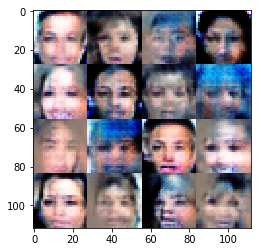

Epoch => 1/1  Discriminator Loss: 1.198 Generator Loss: 0.821
Epoch => 1/1  Discriminator Loss: 1.413 Generator Loss: 0.982
Epoch => 1/1  Discriminator Loss: 1.669 Generator Loss: 1.730
Epoch => 1/1  Discriminator Loss: 1.085 Generator Loss: 0.829
Epoch => 1/1  Discriminator Loss: 0.954 Generator Loss: 0.991
Epoch => 1/1  Discriminator Loss: 1.026 Generator Loss: 0.838
Epoch => 1/1  Discriminator Loss: 1.285 Generator Loss: 1.154
Epoch => 1/1  Discriminator Loss: 1.030 Generator Loss: 1.013
Epoch => 1/1  Discriminator Loss: 1.489 Generator Loss: 0.696
Epoch => 1/1  Discriminator Loss: 1.223 Generator Loss: 1.264


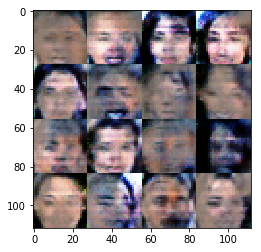

Epoch => 1/1  Discriminator Loss: 0.974 Generator Loss: 0.818
Epoch => 1/1  Discriminator Loss: 1.062 Generator Loss: 1.048
Epoch => 1/1  Discriminator Loss: 1.237 Generator Loss: 1.365
Epoch => 1/1  Discriminator Loss: 1.165 Generator Loss: 1.211
Epoch => 1/1  Discriminator Loss: 1.177 Generator Loss: 1.311
Epoch => 1/1  Discriminator Loss: 1.183 Generator Loss: 0.762
Epoch => 1/1  Discriminator Loss: 1.275 Generator Loss: 0.762
Epoch => 1/1  Discriminator Loss: 1.064 Generator Loss: 0.809
Epoch => 1/1  Discriminator Loss: 1.303 Generator Loss: 1.010
Epoch => 1/1  Discriminator Loss: 1.052 Generator Loss: 0.992


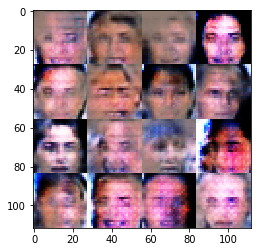

Epoch => 1/1  Discriminator Loss: 1.310 Generator Loss: 0.633
Epoch => 1/1  Discriminator Loss: 1.421 Generator Loss: 0.717
Epoch => 1/1  Discriminator Loss: 1.023 Generator Loss: 0.938
Epoch => 1/1  Discriminator Loss: 1.220 Generator Loss: 0.779
Epoch => 1/1  Discriminator Loss: 1.453 Generator Loss: 0.467
Epoch => 1/1  Discriminator Loss: 1.040 Generator Loss: 0.994
Epoch => 1/1  Discriminator Loss: 1.239 Generator Loss: 1.211
Epoch => 1/1  Discriminator Loss: 1.285 Generator Loss: 0.621
Epoch => 1/1  Discriminator Loss: 1.055 Generator Loss: 0.922
Epoch => 1/1  Discriminator Loss: 1.366 Generator Loss: 0.888


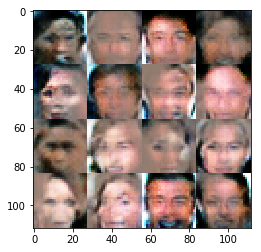

Epoch => 1/1  Discriminator Loss: 1.625 Generator Loss: 0.607
Epoch => 1/1  Discriminator Loss: 1.207 Generator Loss: 1.037
Epoch => 1/1  Discriminator Loss: 1.191 Generator Loss: 1.035
Epoch => 1/1  Discriminator Loss: 0.986 Generator Loss: 1.019
Epoch => 1/1  Discriminator Loss: 1.193 Generator Loss: 0.657
Epoch => 1/1  Discriminator Loss: 1.094 Generator Loss: 0.831
Epoch => 1/1  Discriminator Loss: 0.974 Generator Loss: 1.061
Epoch => 1/1  Discriminator Loss: 0.994 Generator Loss: 1.239
Epoch => 1/1  Discriminator Loss: 1.140 Generator Loss: 0.768
Epoch => 1/1  Discriminator Loss: 1.156 Generator Loss: 0.929


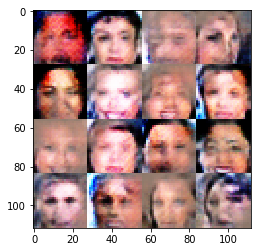

Epoch => 1/1  Discriminator Loss: 0.837 Generator Loss: 1.161
Epoch => 1/1  Discriminator Loss: 1.186 Generator Loss: 1.172
Epoch => 1/1  Discriminator Loss: 1.439 Generator Loss: 0.467
Epoch => 1/1  Discriminator Loss: 1.008 Generator Loss: 1.589
Epoch => 1/1  Discriminator Loss: 1.336 Generator Loss: 0.833
Epoch => 1/1  Discriminator Loss: 1.231 Generator Loss: 0.630
Epoch => 1/1  Discriminator Loss: 1.412 Generator Loss: 0.557
Epoch => 1/1  Discriminator Loss: 1.156 Generator Loss: 1.024
Epoch => 1/1  Discriminator Loss: 1.644 Generator Loss: 0.601
Epoch => 1/1  Discriminator Loss: 0.920 Generator Loss: 0.942


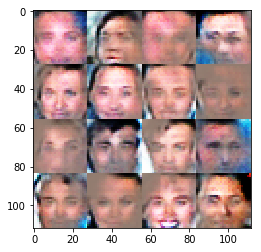

Epoch => 1/1  Discriminator Loss: 1.522 Generator Loss: 0.760
Epoch => 1/1  Discriminator Loss: 0.789 Generator Loss: 1.290
Epoch => 1/1  Discriminator Loss: 1.279 Generator Loss: 0.608
Epoch => 1/1  Discriminator Loss: 1.177 Generator Loss: 0.791
Epoch => 1/1  Discriminator Loss: 1.128 Generator Loss: 0.930
Epoch => 1/1  Discriminator Loss: 0.969 Generator Loss: 1.383
Epoch => 1/1  Discriminator Loss: 1.093 Generator Loss: 1.197
Epoch => 1/1  Discriminator Loss: 1.024 Generator Loss: 1.002
Epoch => 1/1  Discriminator Loss: 1.265 Generator Loss: 0.757
Epoch => 1/1  Discriminator Loss: 1.108 Generator Loss: 0.929


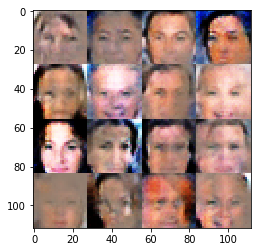

Epoch => 1/1  Discriminator Loss: 1.047 Generator Loss: 0.810
Epoch => 1/1  Discriminator Loss: 1.267 Generator Loss: 1.014
Epoch => 1/1  Discriminator Loss: 1.185 Generator Loss: 0.844
Epoch => 1/1  Discriminator Loss: 1.223 Generator Loss: 1.560
Epoch => 1/1  Discriminator Loss: 1.134 Generator Loss: 0.670
Epoch => 1/1  Discriminator Loss: 1.289 Generator Loss: 0.575
Epoch => 1/1  Discriminator Loss: 1.327 Generator Loss: 1.742
Epoch => 1/1  Discriminator Loss: 1.066 Generator Loss: 1.177
Epoch => 1/1  Discriminator Loss: 1.391 Generator Loss: 0.703
Epoch => 1/1  Discriminator Loss: 1.078 Generator Loss: 0.851


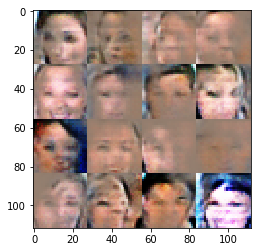

Epoch => 1/1  Discriminator Loss: 1.145 Generator Loss: 0.933
Epoch => 1/1  Discriminator Loss: 1.431 Generator Loss: 1.547
Epoch => 1/1  Discriminator Loss: 1.383 Generator Loss: 0.808
Epoch => 1/1  Discriminator Loss: 1.128 Generator Loss: 0.828
Epoch => 1/1  Discriminator Loss: 1.085 Generator Loss: 0.813
Epoch => 1/1  Discriminator Loss: 0.857 Generator Loss: 1.208
Epoch => 1/1  Discriminator Loss: 3.343 Generator Loss: 3.414
Epoch => 1/1  Discriminator Loss: 1.020 Generator Loss: 1.216
Epoch => 1/1  Discriminator Loss: 1.364 Generator Loss: 1.097
Epoch => 1/1  Discriminator Loss: 0.991 Generator Loss: 0.945


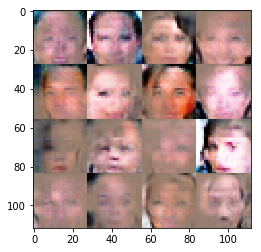

Epoch => 1/1  Discriminator Loss: 1.195 Generator Loss: 1.182
Epoch => 1/1  Discriminator Loss: 0.934 Generator Loss: 1.226
Epoch => 1/1  Discriminator Loss: 0.534 Generator Loss: 2.356
Epoch => 1/1  Discriminator Loss: 1.437 Generator Loss: 1.851
Epoch => 1/1  Discriminator Loss: 1.187 Generator Loss: 0.815
Epoch => 1/1  Discriminator Loss: 0.987 Generator Loss: 0.894
Epoch => 1/1  Discriminator Loss: 1.176 Generator Loss: 0.754
Epoch => 1/1  Discriminator Loss: 1.230 Generator Loss: 0.917
Epoch => 1/1  Discriminator Loss: 1.336 Generator Loss: 0.654
Epoch => 1/1  Discriminator Loss: 0.776 Generator Loss: 1.371


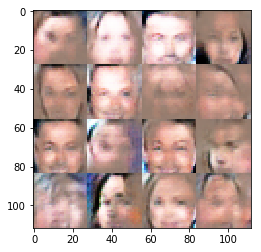

Epoch => 1/1  Discriminator Loss: 1.325 Generator Loss: 0.670
Epoch => 1/1  Discriminator Loss: 1.171 Generator Loss: 1.143
Epoch => 1/1  Discriminator Loss: 1.077 Generator Loss: 1.393
Epoch => 1/1  Discriminator Loss: 1.131 Generator Loss: 0.964
Epoch => 1/1  Discriminator Loss: 1.389 Generator Loss: 1.133
Epoch => 1/1  Discriminator Loss: 1.313 Generator Loss: 0.719
Epoch => 1/1  Discriminator Loss: 0.948 Generator Loss: 1.126
Epoch => 1/1  Discriminator Loss: 1.582 Generator Loss: 0.493
Epoch => 1/1  Discriminator Loss: 1.178 Generator Loss: 0.975
Epoch => 1/1  Discriminator Loss: 1.100 Generator Loss: 1.025


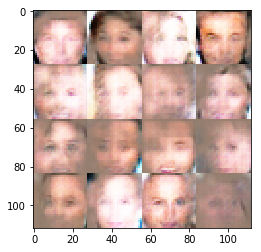

Epoch => 1/1  Discriminator Loss: 1.104 Generator Loss: 1.327
Epoch => 1/1  Discriminator Loss: 1.268 Generator Loss: 1.036
Epoch => 1/1  Discriminator Loss: 1.206 Generator Loss: 0.739
Epoch => 1/1  Discriminator Loss: 1.295 Generator Loss: 0.652
Epoch => 1/1  Discriminator Loss: 1.288 Generator Loss: 0.699
Epoch => 1/1  Discriminator Loss: 1.184 Generator Loss: 0.998
Epoch => 1/1  Discriminator Loss: 2.196 Generator Loss: 0.211
Epoch => 1/1  Discriminator Loss: 1.149 Generator Loss: 0.839
Epoch => 1/1  Discriminator Loss: 1.469 Generator Loss: 1.136
Epoch => 1/1  Discriminator Loss: 1.136 Generator Loss: 0.829


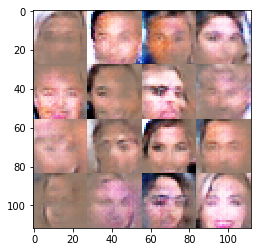

Epoch => 1/1  Discriminator Loss: 1.417 Generator Loss: 1.164
Epoch => 1/1  Discriminator Loss: 1.133 Generator Loss: 0.988
Epoch => 1/1  Discriminator Loss: 1.235 Generator Loss: 1.161
Epoch => 1/1  Discriminator Loss: 1.220 Generator Loss: 0.957
Epoch => 1/1  Discriminator Loss: 1.202 Generator Loss: 1.140
Epoch => 1/1  Discriminator Loss: 1.161 Generator Loss: 1.053
Epoch => 1/1  Discriminator Loss: 1.041 Generator Loss: 1.414
Epoch => 1/1  Discriminator Loss: 1.675 Generator Loss: 0.392
Epoch => 1/1  Discriminator Loss: 1.176 Generator Loss: 0.823
Epoch => 1/1  Discriminator Loss: 1.161 Generator Loss: 1.217


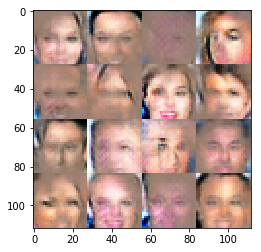

Epoch => 1/1  Discriminator Loss: 1.414 Generator Loss: 0.705
Epoch => 1/1  Discriminator Loss: 1.216 Generator Loss: 0.763
Epoch => 1/1  Discriminator Loss: 0.991 Generator Loss: 0.852
Epoch => 1/1  Discriminator Loss: 1.059 Generator Loss: 1.056
Epoch => 1/1  Discriminator Loss: 1.162 Generator Loss: 1.277
Epoch => 1/1  Discriminator Loss: 1.176 Generator Loss: 0.838
Epoch => 1/1  Discriminator Loss: 1.289 Generator Loss: 0.981
Epoch => 1/1  Discriminator Loss: 1.171 Generator Loss: 1.774
Epoch => 1/1  Discriminator Loss: 1.262 Generator Loss: 0.847
Epoch => 1/1  Discriminator Loss: 1.291 Generator Loss: 0.627


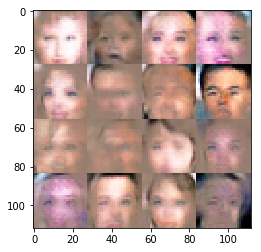

Epoch => 1/1  Discriminator Loss: 1.108 Generator Loss: 1.034
Epoch => 1/1  Discriminator Loss: 1.082 Generator Loss: 1.091
Epoch => 1/1  Discriminator Loss: 1.240 Generator Loss: 0.769
Epoch => 1/1  Discriminator Loss: 1.257 Generator Loss: 0.831
Epoch => 1/1  Discriminator Loss: 1.273 Generator Loss: 0.649
Epoch => 1/1  Discriminator Loss: 1.185 Generator Loss: 0.996
Epoch => 1/1  Discriminator Loss: 0.976 Generator Loss: 1.348
Epoch => 1/1  Discriminator Loss: 1.157 Generator Loss: 0.956
Epoch => 1/1  Discriminator Loss: 1.382 Generator Loss: 0.759
Epoch => 1/1  Discriminator Loss: 1.140 Generator Loss: 0.661


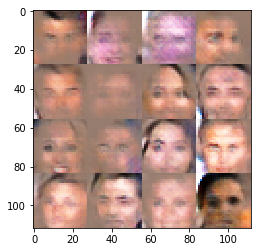

Epoch => 1/1  Discriminator Loss: 1.369 Generator Loss: 0.935
Epoch => 1/1  Discriminator Loss: 1.224 Generator Loss: 1.300
Epoch => 1/1  Discriminator Loss: 1.168 Generator Loss: 1.054
Epoch => 1/1  Discriminator Loss: 1.494 Generator Loss: 0.476
Epoch => 1/1  Discriminator Loss: 1.042 Generator Loss: 0.902
Epoch => 1/1  Discriminator Loss: 1.122 Generator Loss: 0.832
Epoch => 1/1  Discriminator Loss: 1.285 Generator Loss: 0.759
Epoch => 1/1  Discriminator Loss: 1.271 Generator Loss: 0.707
Epoch => 1/1  Discriminator Loss: 1.032 Generator Loss: 0.934
Epoch => 1/1  Discriminator Loss: 1.499 Generator Loss: 2.008


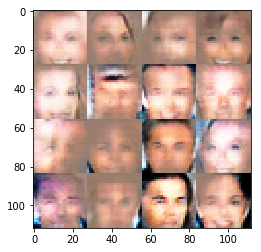

Epoch => 1/1  Discriminator Loss: 1.409 Generator Loss: 0.950
Epoch => 1/1  Discriminator Loss: 1.337 Generator Loss: 1.311
Epoch => 1/1  Discriminator Loss: 1.372 Generator Loss: 0.644
Epoch => 1/1  Discriminator Loss: 1.493 Generator Loss: 0.649
Epoch => 1/1  Discriminator Loss: 0.920 Generator Loss: 1.043
Epoch => 1/1  Discriminator Loss: 0.912 Generator Loss: 1.103


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.